In [1]:
import warnings
warnings.filterwarnings('ignore')

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from keras.applications.vgg19 import VGG19
from tensorflow.keras import layers
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing import image
from keras.layers import Dense,GlobalAveragePooling2D
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

BATCH_SIZE = 64 # ubah ke 64
n_classes = 6

# VGG19 base model
conv_base = VGG19(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)

# Freeze all layers except the last two
for layer in conv_base.layers:
    layer.trainable = False

# Top model
top_model = conv_base.output
top_model = GlobalAveragePooling2D()(top_model)
top_model = Dense(1024,activation='relu')(top_model) 
top_model = Dense(1024,activation='relu')(top_model) 
top_model = Dense(512,activation='relu')(top_model) 
output_layer = Dense(n_classes, activation='softmax')(top_model)

# Final Model
model = Model(inputs=conv_base.input, outputs=output_layer)

In [2]:
def plot_random_images(generator, num_images=20):
    # Get a batch of data from the generator
    images, labels = next(generator)

    # Get random indices for selecting images
    random_indices = np.random.choice(images.shape[0], num_images, replace=False)

    # Plot the selected images
    fig, axs = plt.subplots(4, 5, figsize=(15, 12))
    fig.suptitle('Random 20 Images from the Generator', fontsize=16)

    for i, ax in enumerate(axs.flatten()):
        index = random_indices[i]
        image = images[index]
        label = labels[index]
        # Ensure pixel values are in valid range [0, 1]
        image = np.clip(image, 0, 1)

        # Display the image
        ax.imshow(image)
        ax.set_title(f'Class: {np.argmax(label)}')
        ax.axis('off')

    plt.show()

In [3]:
data_path = '../relabelled_garbage_classification_with_775_images'

Found 39277 images belonging to 7 classes.


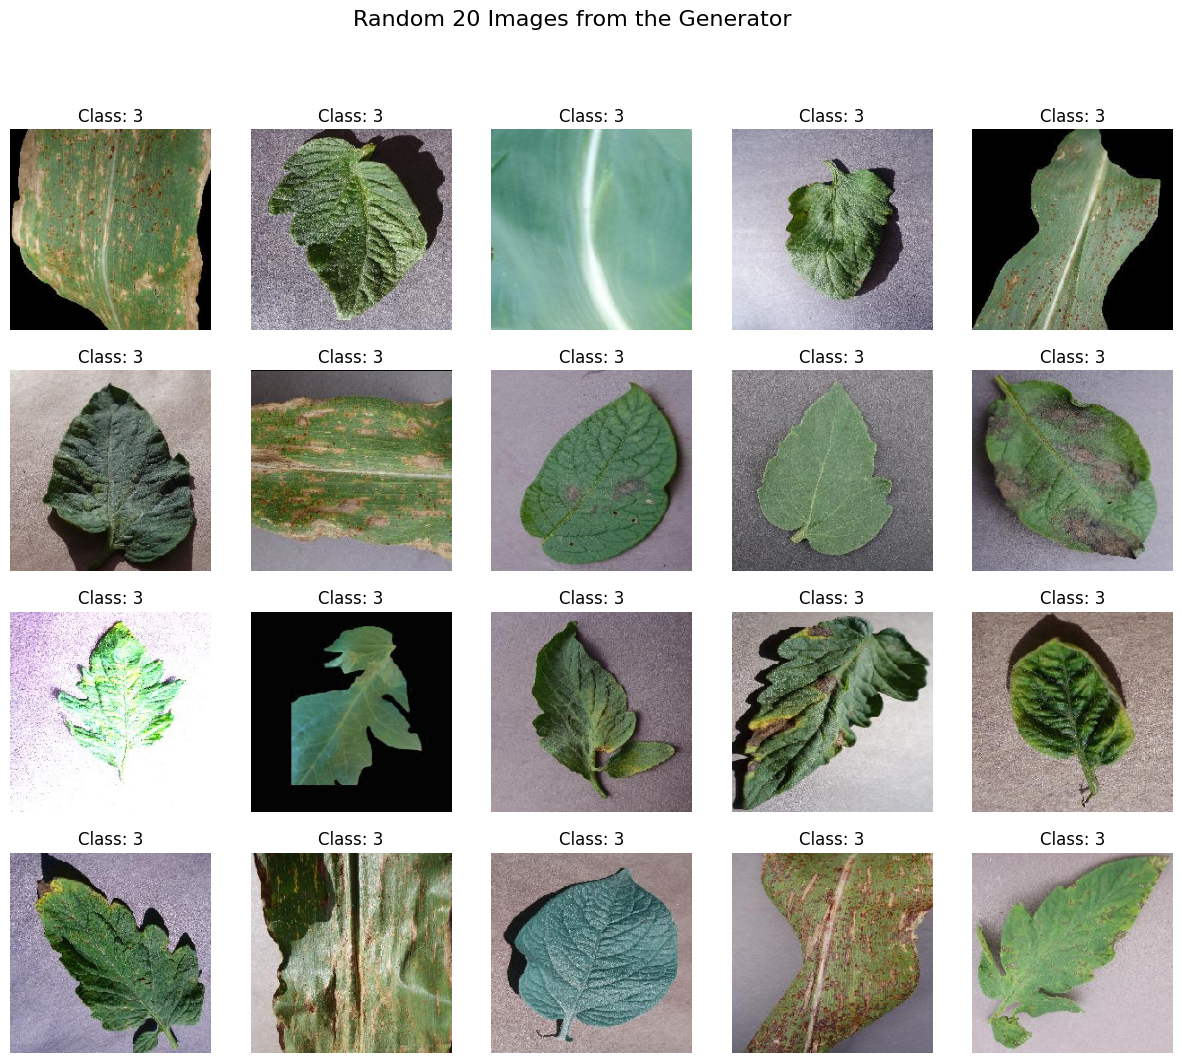

In [4]:
# Parameters
data_path = 'D:\MASSIVE PROJECT\PROJECT MASSIVE\Massive_disease_classification_using_Convolutional_Neural_Network'  # Replace with the correct path to your dataset
BATCH_SIZE = 64 # Define your batch size

# Create ImageDataGenerator and flow_from_directory
datagen = ImageDataGenerator(rescale=1./255)
original_data = datagen.flow_from_directory(
    data_path, 
    target_size=(224, 224), 
    batch_size=BATCH_SIZE, 
    class_mode="categorical"
)

# Plot random images
plot_random_images(original_data)

Found 39277 images belonging to 7 classes.


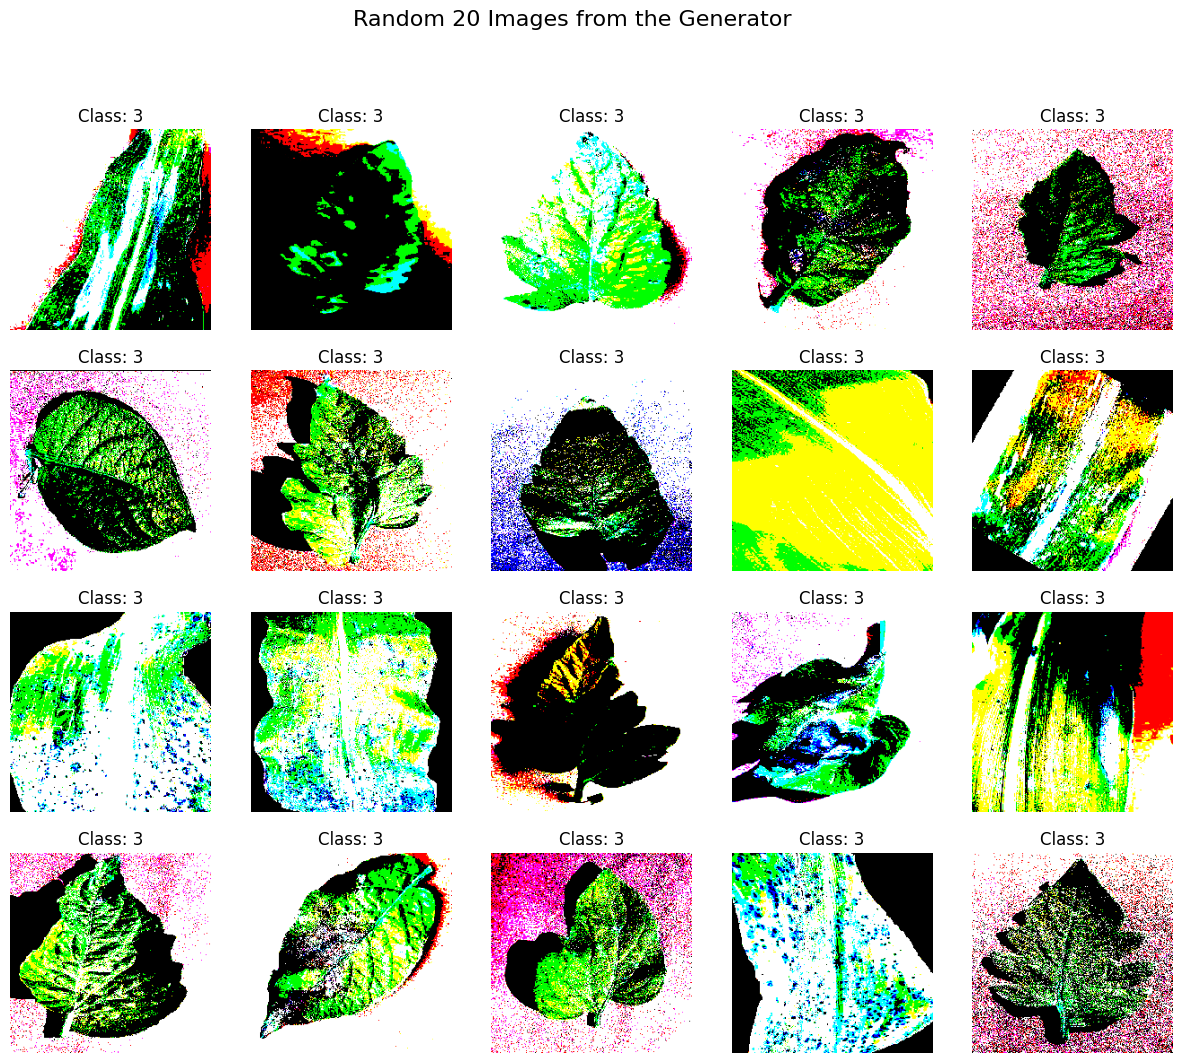

In [5]:
gen_train = ImageDataGenerator(preprocessing_function=preprocess_input) # VGG19 preprocessing
full_data = gen_train.flow_from_directory(data_path, target_size = (224, 224), batch_size = BATCH_SIZE, class_mode="categorical")
plot_random_images(full_data)

In [6]:
# Extract filenames and labels from the DirectoryIterator
filenames = full_data.filenames
labels = full_data.labels
class_mapping = {value: str(key) for key, value in full_data.class_indices.items()}
labels = [class_mapping[label] for label in labels]

filenames[:5], labels[:5]

(['Dataset tanaman\\Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot\\00120a18-ff90-46e4-92fb-2b7a10345bd3___RS_GLSp 9357.JPG',
  'Dataset tanaman\\Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot\\00120a18-ff90-46e4-92fb-2b7a10345bd3___RS_GLSp 9357_270deg.JPG',
  'Dataset tanaman\\Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot\\00120a18-ff90-46e4-92fb-2b7a10345bd3___RS_GLSp 9357_90deg.JPG',
  'Dataset tanaman\\Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot\\00120a18-ff90-46e4-92fb-2b7a10345bd3___RS_GLSp 9357_new30degFlipLR.JPG',
  'Dataset tanaman\\Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot\\00a20f6f-e8bd-4453-9e25-36ea70feb626___RS_GLSp 4655.JPG'],
 ['Dataset tanaman',
  'Dataset tanaman',
  'Dataset tanaman',
  'Dataset tanaman',
  'Dataset tanaman'])

In [ ]:
# Split the data into training and testing sets
train_filenames, test_filenames, train_labels, test_labels = train_test_split(
    filenames, labels, test_size=0.1, random_state=42)

# Create DataFrames for training and testing
train_df = pd.DataFrame({'filename': train_filenames, 'class': train_labels})
test_df = pd.DataFrame({'filename': test_filenames, 'class': test_labels})

# Create separate generators for training and testing using flow_from_dataframe
train_data = gen_train.flow_from_dataframe(train_df, directory=data_path, target_size=(224, 224),
                                           batch_size=BATCH_SIZE, class_mode="categorical",
                                           shuffle=True, seed=42)

test_data = gen_train.flow_from_dataframe(test_df, directory=data_path, target_size=(224, 224),
                                          batch_size=BATCH_SIZE, class_mode="categorical",
                                          shuffle=False)

Found 35349 validated image filenames belonging to 2 classes.
Found 3928 validated image filenames belonging to 2 classes.


: 

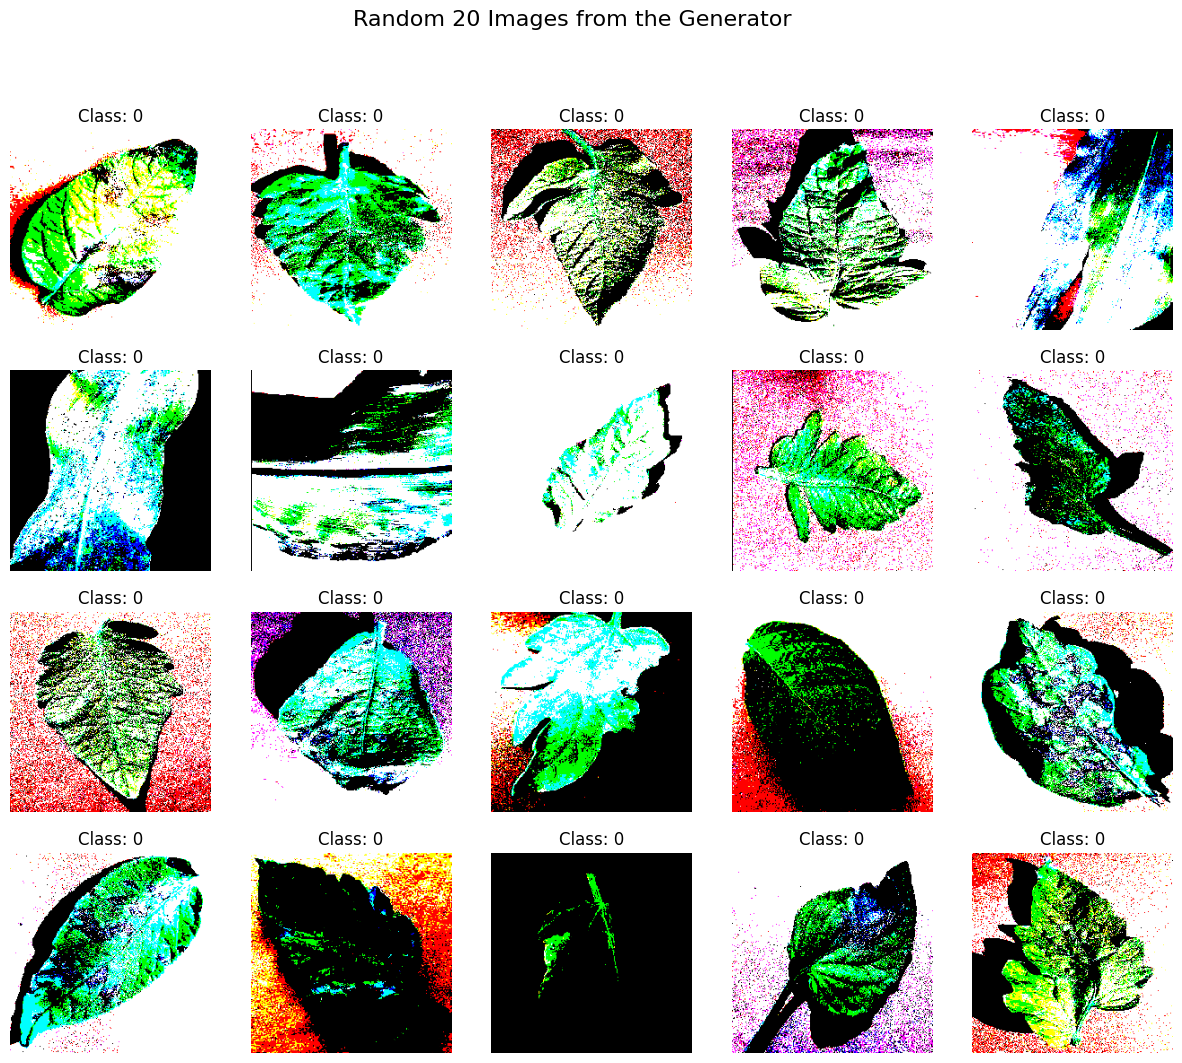

Epoch 1/5


In [ ]:
plot_random_images(train_data)

# Load the VGG19 model pre-trained on ImageNet, without the top layers
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Load VGG19 model pre-trained on ImageNet
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # freeze base model

# Add custom layers
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dense(len(train_data.class_indices), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=x)

# Compile
opt = Adam(learning_rate=0.0001)
model.compile(
    optimizer=opt, 
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
checkpoint = ModelCheckpoint(
    filepath='model.vgg19.keras',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

early = EarlyStopping(
    monitor='val_loss', 
    patience=15, 
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=5, 
    min_lr=1e-6
)

# Training
num_epochs = 5
history = model.fit(
    train_data,
    steps_per_epoch=len(train_data) // 10,   # 🚀 lebih sedikit step → lebih cepat
    epochs=num_epochs,
    validation_data=test_data,
    validation_steps=len(test_data) // 10,   # 🚀 kurangi step val
    callbacks=[checkpoint, early, reduce_lr]
)

In [ ]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 64, 64, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │         1,02

 Total params: 23,174,732 (88.40 MB)

 Trainable params: 1,050,114 (4.01 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

 Optimizer params: 2,100,234 (8.01 MB)

In [ ]:
n_steps = train_data.samples // BATCH_SIZE
n_val_steps = test_data.samples // BATCH_SIZE
n_steps, n_val_steps

(552, 61)

In [ ]:
result = model.fit(
    train_data, 
    epochs=num_epochs, 
    steps_per_epoch=n_steps,
    validation_data=test_data, 
    validation_steps=n_val_steps,
    callbacks=[early, checkpoint, reduce_lr]
)

Epoch 1/5
552/552 ━━━━━━━━━━━━━━━━━━━━ 0s 935ms/step - accuracy: 0.9984 - loss: 0.0251
Epoch 1: val_loss improved from 0.02099 to 0.02065, saving model to model.vgg19.keras
552/552 ━━━━━━━━━━━━━━━━━━━━ 574s 1s/step - accuracy: 0.9984 - loss: 0.0251 - val_accuracy: 0.9987 - val_loss: 0.0206 - learning_rate: 1.0000e-04
Epoch 2/5
  1/552 ━━━━━━━━━━━━━━━━━━━━ 8:07 885ms/step - accuracy: 1.0000 - loss: 1.3238e-05
Epoch 2: val_loss did not improve from 0.02065
552/552 ━━━━━━━━━━━━━━━━━━━━ 1s 875us/step - accuracy: 1.0000 - loss: 1.3238e-05 - val_accuracy: 0.9583 - val_loss: 0.6716 - learning_rate: 1.0000e-04
Epoch 3/5
552/552 ━━━━━━━━━━━━━━━━━━━━ 0s 962ms/step - accuracy: 0.9987 - loss: 0.0202
Epoch 3: val_loss improved from 0.02065 to 0.02064, saving model to model.vgg19.keras
552/552 ━━━━━━━━━━━━━━━━━━━━ 590s 1s/step - accuracy: 0.9987 - loss: 0.0202 - val_accuracy: 0.9987 - val_loss: 0.0206 - learning_rate: 1.0000e-04
Epoch 4/5
  1/552 ━━━━━━━━━━━━━━━━━━━━ 8:22 912ms/step - accuracy: 1.00

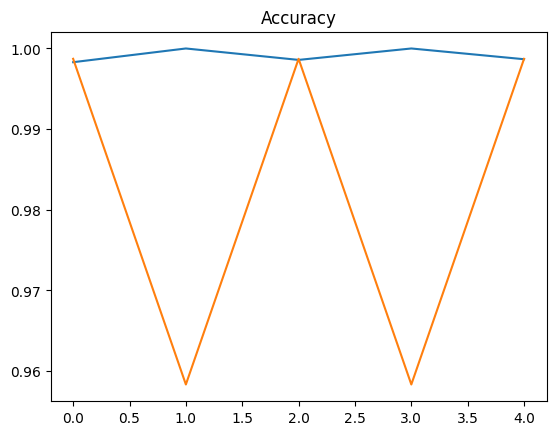

In [ ]:
plt.title("Accuracy")
plt.plot(result.history["accuracy"])
plt.plot(result.history["val_accuracy"])
plt.show()

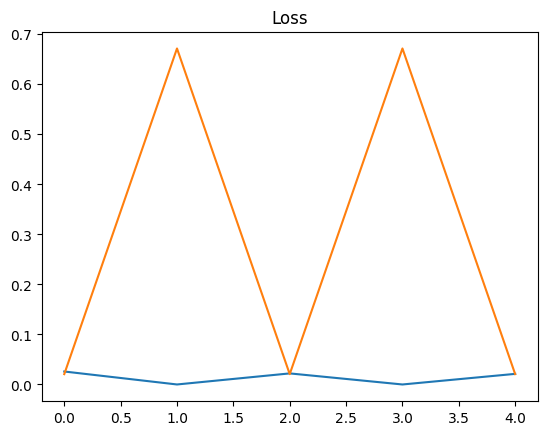

In [ ]:
plt.title("Loss")
plt.plot(result.history["loss"])
plt.plot(result.history["val_loss"])
plt.show()

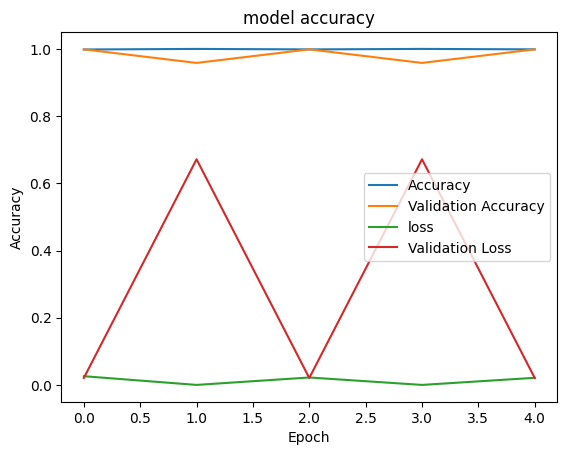

In [ ]:
plt.plot(result.history['accuracy'])
plt.plot(result.history['val_accuracy'])
plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

In [ ]:
model.save("model_vgg19.h5")

62/62 ━━━━━━━━━━━━━━━━━━━━ 58s 929ms/step


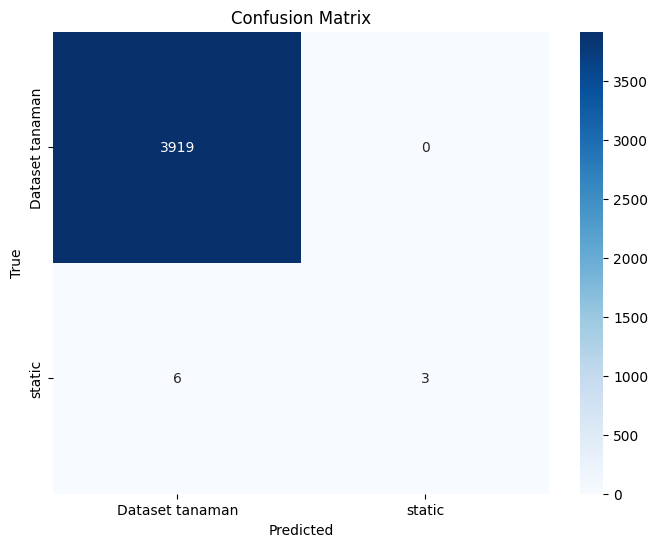

                 precision    recall  f1-score   support

Dataset tanaman       1.00      1.00      1.00      3919
         static       1.00      0.33      0.50         9

       accuracy                           1.00      3928
      macro avg       1.00      0.67      0.75      3928
   weighted avg       1.00      1.00      1.00      3928



In [ ]:
predictions = model.predict(test_data)

# Get the predicted class labels
predicted_labels = np.argmax(predictions, axis=1)

# Get the true class labels
true_labels = test_data.classes

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_data.class_indices.keys(),
            yticklabels=test_data.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
class_names = list(test_data.class_indices.keys())
print(classification_report(true_labels, predicted_labels, target_names=class_names))

In [ ]:
output_class = ["battery", "glass", "metal","organic", "paper", "plastic"]

def preprocessing_input(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img) # VGG16 preprocess_input
    return img

def plot_images(original, preprocessed):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    axs[0].imshow(original)
    axs[0].set_title('Original Image')
    axs[0].axis('off')

    # Remove the batch dimension for display
    preprocessed = np.squeeze(preprocessed, axis=0)

    axs[1].imshow(preprocessed)
    axs[1].set_title('Preprocessed Image')
    axs[1].axis('off')

    plt.show()

def predict_user(img_path):
    img = preprocessing_input(img_path)
    plot_images(Image.open(img_path), img)
    predicted_array = model.predict(img)
    predicted_value = output_class[np.argmax(predicted_array)]
    predicted_accuracy = round(np.max(predicted_array) * 100, 2)
    print("Your waste material is", predicted_value, "with", predicted_accuracy, "% accuracy.")

## Test with new data

In [ ]:
predict_user('indomie.jpg')

FileNotFoundError: [Errno 2] No such file or directory: 'indomie.jpg'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


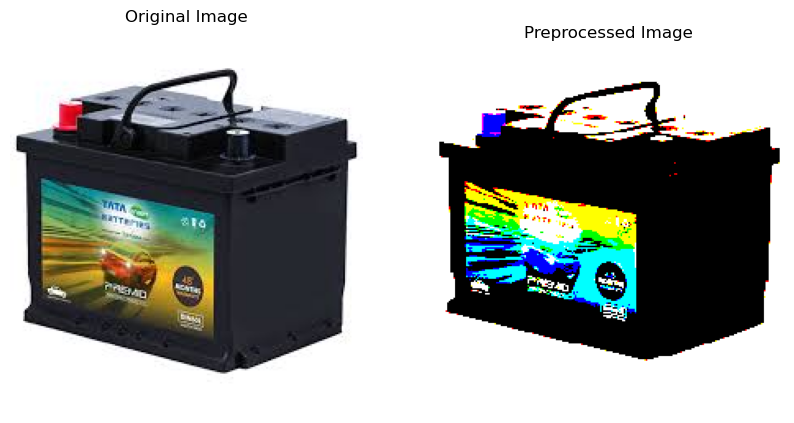

1/1 [==============================] - 0s 82ms/step
Your waste material is battery with 100.0 % accuracy.


In [ ]:
predict_user('battery.jpeg')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


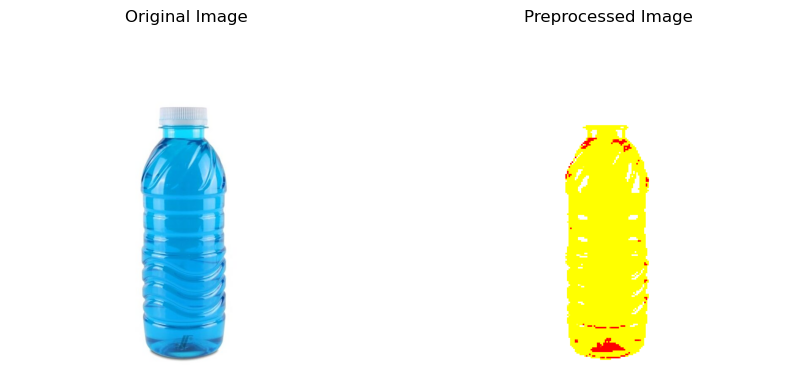

1/1 [==============================] - 0s 55ms/step
Your waste material is plastic with 100.0 % accuracy.


In [ ]:
predict_user('botol.jpg')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


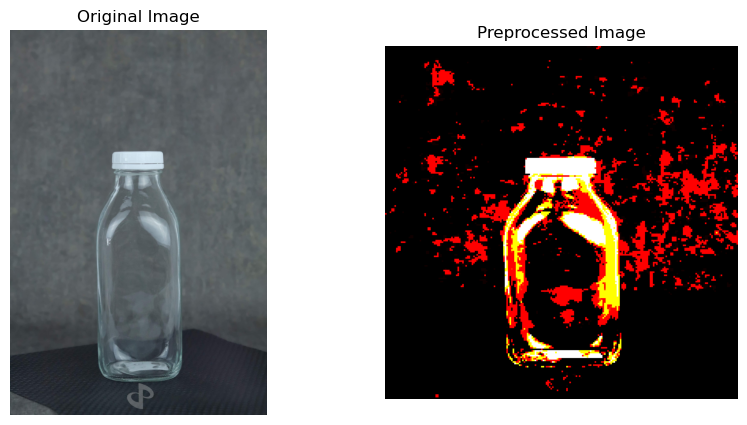

1/1 [==============================] - 0s 58ms/step
Your waste material is glass with 97.31 % accuracy.


In [ ]:
predict_user('botolkaca.jpg')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


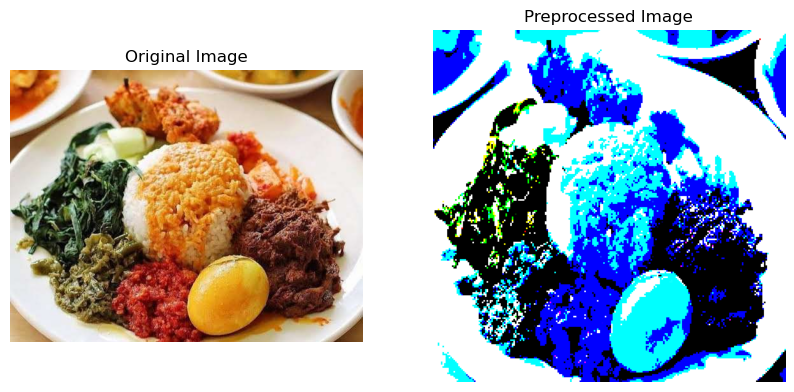

1/1 [==============================] - 0s 93ms/step
Your waste material is organic with 100.0 % accuracy.


In [ ]:
predict_user('naspad.jpeg')